2025-07-26 12:17:06 - INFO - Initializing configuration...
2025-07-26 12:17:06 - INFO - Configuration loaded.
2025-07-26 12:17:06 - INFO - --- Stage 1: Loading and aligning data ---
2025-07-26 12:17:06 - INFO - 'returns_df' loaded successfully.
2025-07-26 12:17:06 - INFO - 'presence_matrix' loaded successfully.
2025-07-26 12:17:06 - INFO - Data loaded and aligned successfully.
2025-07-26 12:17:06 - INFO - --- Stage 2: Patching SPX data holes ---
2025-07-26 12:17:06 - INFO - Patch file './data/spx_patch.parquet' already exists. Skipping creation.
2025-07-26 12:17:06 - INFO - Successfully applied patch from './data/spx_patch.parquet'.
2025-07-26 12:17:06 - INFO - SPX data patched successfully.
2025-07-26 12:17:06 - INFO - --- Stage 3: Identifying rebalancing dates ---
2025-07-26 12:17:06 - INFO - Found 540 rebalancing dates from 1980-01-31 to 2024-12-31.
2025-07-26 12:17:06 - INFO - --- Stage 4: Differentiating column types ---
2025-07-26 12:17:06 - INFO - Identified 131 stock columns an

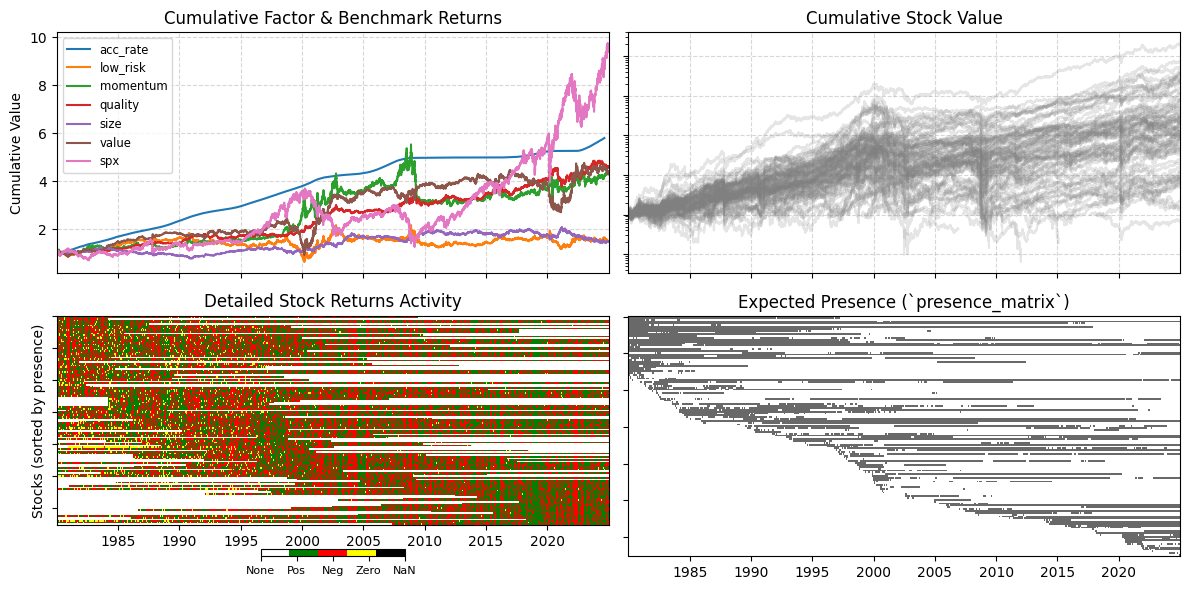

2025-07-26 12:17:12 - INFO - Dashboard generated.
2025-07-26 12:17:12 - INFO - --- Stage 6: Pre-calculating prices and volatility proxies ---
2025-07-26 12:17:13 - INFO - Prices and volatility proxies calculated.
2025-07-26 12:17:13 - INFO - --- Stage 7: Running the daily backtest loop ---


Backtesting Progress: 100%|██████████| 11344/11344 [00:30<00:00, 377.58it/s]

2025-07-26 12:17:43 - INFO - Backtest complete.
2025-07-26 12:17:43 - INFO - --- Stage 7.1: Visualizing portfolio leverage (saving to ./leverage_and_volatility.png) ---


2025-07-26 12:17:44 - INFO - Leverage plot saved to ./leverage_and_volatility.png


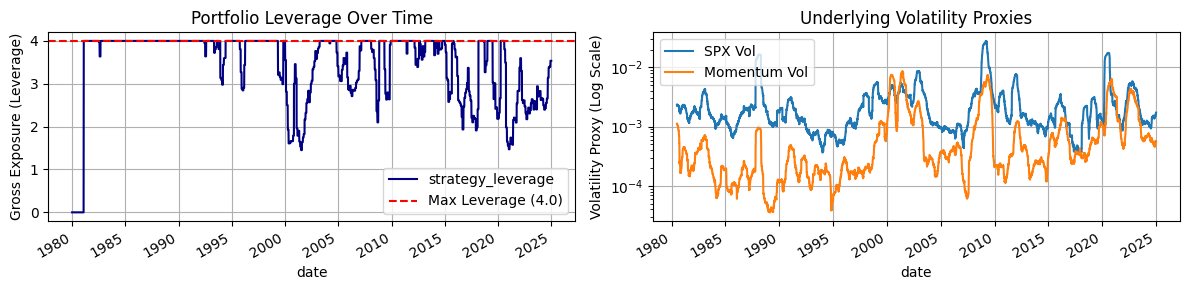

2025-07-26 12:17:45 - INFO - --- Stage 8: Calculating final performance metrics ---
2025-07-26 12:17:45 - INFO - Metrics calculated.
2025-07-26 12:17:45 - INFO - --- Stage 9: Generating final performance report ---
2025-07-26 12:17:46 - INFO - Performance summary plot saved to ./strategy_performance.png


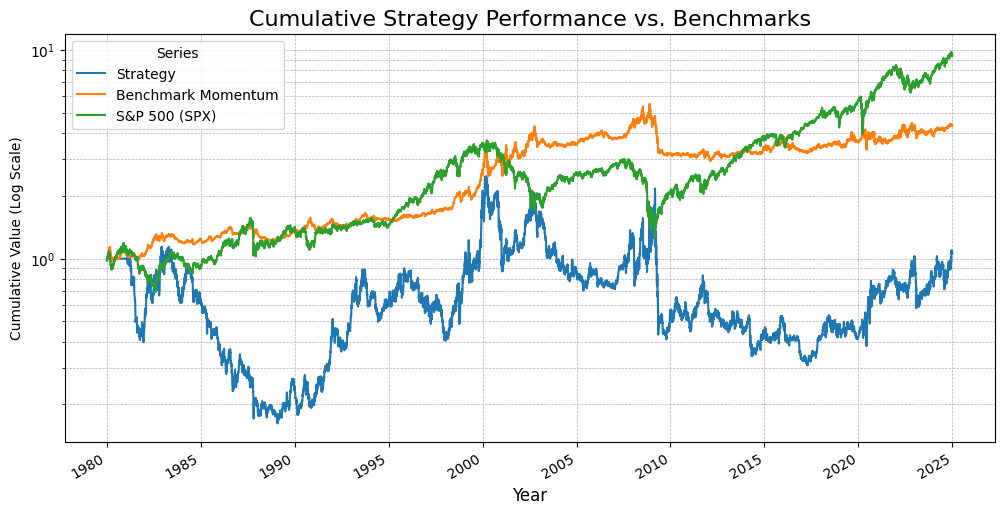

2025-07-26 12:17:46 - INFO - Performance metrics saved to ./strategy_report.json
2025-07-26 12:17:46 - INFO - 
      Strategy Performance Summary
   Annualized Return                 0.12%
   Annualized Volatility            36.65%
   Annualized Sharpe Ratio           -0.10
   Annualized Alpha (vs 6 factors)   -1.08%
   Information Ratio                 -0.04
2025-07-26 12:17:46 - INFO - Report generated. Task complete.


In [ ]:
import pandas as pd
from helpers.plotting_utils import plot_dashboard, plot_leverage_and_volatility
from helpers.data_utils import create_spx_patch_file, data_loader, apply_spx_hole_patch, generate_custom_presence_matrix
from helpers.strategy_logic import get_base_weights, get_risk_scale
from helpers.reporting_utils import calculate_performance_metrics, plot_performance_summary
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from helpers.logger_setup import setup_logger

# --- Setup Logger ---
log = setup_logger('backtest_runner', level=logging.INFO) 

# --- Configuration ---
log.info("Initializing configuration...")
# --- Input Files ---
returns_file_path = './data/returns_df.parquet'
presence_file_path = './data/presence_matrix.parquet'
patch_filename = './data/spx_patch.parquet'
EXTERNAL_PRESENCE = True

# --- Output Files ---
dashboard_output_path = './dashboard_summary.png'
leverage_output_path = './leverage_and_volatility.png'
performance_output_path = './strategy_performance.png'
save_json_path = './strategy_report.json'

# --- Strategy Parameters ---
percentile_leg = 0.2
non_stock_columns = [
    'acc_rate', 'low_risk', 'momentum',
    'quality', 'size', 'value', 'spx'
]
figsize = (12, 6)
log.info("Configuration loaded.")

# --- Stage 1: Load Data ---
log.info("--- Stage 1: Loading and aligning data ---")
data = data_loader(
    returns_file_path=returns_file_path,
    presence_file_path=presence_file_path,
    non_stock_columns=non_stock_columns
)
if not data:
    log.critical("Data loading failed. Halting execution.")
    raise SystemExit("Data loading failed.")
    
presence_matrix = data['presence_matrix']
returns_df = data['returns_df']
assert returns_df.index.equals(presence_matrix.index), "Indices of returns_df and presence_matrix do not match!"
log.info("Data loaded and aligned successfully.")

# --- Stage 2: Patch SPX Data ---
log.info("--- Stage 2: Patching SPX data holes ---")
patch_successful = False
try:
    if create_spx_patch_file(returns_df, patch_filename=patch_filename, force_creation=False):
        patch_successful = apply_spx_hole_patch(patch_filename, returns_df)
except Exception as e:
    log.warning(f"An unexpected error occurred during SPX patching. Proceeding without patch. Details: {e}")

if patch_successful:
    log.info("SPX data patched successfully.")
else:
    log.warning("Could not apply SPX patch. Proceeding with original data.")

# --- Stage 3: Identify Rebalancing Dates ---
log.info("--- Stage 3: Identifying rebalancing dates ---")
rebal_dates = set(returns_df.index.to_series().resample('ME').last())
log.info(f"Found {len(rebal_dates)} rebalancing dates from {min(rebal_dates).date()} to {max(rebal_dates).date()}.")

# --- Stage 4: Identify Column Types ---
log.info("--- Stage 4: Differentiating column types ---")
stock_columns = list(set(returns_df.columns) - set(non_stock_columns))
log.info(f"Identified {len(stock_columns)} stock columns and {len(non_stock_columns)} factor columns.")

if not EXTERNAL_PRESENCE:
    log.info("External presence matrix is disabled. Generating a custom one based on trading activity...")
    presence_matrix = generate_custom_presence_matrix(returns_df=returns_df, stock_columns=stock_columns)
    log.info("Custom presence matrix generated.")

# --- Stage 5: Initial Data Visualization ---
log.info(f"--- Stage 5: Generating data overview dashboard (saving to {dashboard_output_path}) ---")
plot_dashboard(
    returns_df=returns_df,
    presence_matrix=presence_matrix,
    non_stock_columns=non_stock_columns,
    stock_columns=stock_columns,
    figsize=figsize,
    save_png_path=dashboard_output_path
)
log.info("Dashboard generated.")

# --- Stage 6: Pre-calculate Data for Backtest ---
log.info("--- Stage 6: Pre-calculating prices and volatility proxies ---")
prices_df = (1 + returns_df[stock_columns].fillna(0)).cumprod()
returns_for_vol = returns_df[['spx', 'momentum']]
squared_returns = returns_for_vol**2
rolling_sum_sq = squared_returns.rolling(window=126).sum()
vol_proxy_df = (rolling_sum_sq * 21 / 126).shift(1)
log.info("Prices and volatility proxies calculated.")

# --- Stage 7: Run Main Backtest Loop ---
log.info("--- Stage 7: Running the daily backtest loop ---")
current_weights = pd.Series(0.0, index=stock_columns)
strategy_returns = pd.Series(0.0, index=returns_df.index, dtype=float, name="strategy_returns")
strategy_leverage = pd.Series(0.0, index=returns_df.index, dtype=float, name="strategy_leverage")
current_leverage = 0.0

for i in tqdm(range(1, len(returns_df.index)), desc="Backtesting Progress"):
    date = returns_df.index[i-1]
    if date in rebal_dates:
        base_weights = get_base_weights(date, presence_matrix, prices_df, stock_columns, percentile_leg=percentile_leg)
        w_scale = get_risk_scale(date, vol_proxy_df)
        current_weights = base_weights * w_scale
        current_leverage = base_weights.abs().sum() * w_scale
    daily_return = (current_weights * returns_df.iloc[i].fillna(0)).sum()
    strategy_returns.iloc[i] = daily_return
    strategy_leverage.iloc[i] = current_leverage
log.info("Backtest complete.")

# --- Stage 7.1: Visualize Leverage ---
log.info(f"--- Stage 7.1: Visualizing portfolio leverage (saving to {leverage_output_path}) ---")
plot_leverage_and_volatility(
    strategy_leverage=strategy_leverage,
    vol_proxy_df=vol_proxy_df,
    figsize=(figsize[0], figsize[1] / 2),
    save_png_path=leverage_output_path
)

# --- Stage 8: Calculate Performance Metrics ---
log.info("--- Stage 8: Calculating final performance metrics ---")
metrics = calculate_performance_metrics(
    strategy_returns=strategy_returns,
    returns_df=returns_df
)
log.info("Metrics calculated.")

# --- Stage 9: Generate Final Report ---
log.info(f"--- Stage 9: Generating final performance report ---")
plot_performance_summary(
    strategy_returns=strategy_returns,
    returns_df=returns_df,
    metrics=metrics,
    save_png_path=performance_output_path,
    save_json_path=save_json_path,
    figsize=figsize
)
log.info("Report generated. Task complete.")